<a href="https://colab.research.google.com/github/dsrajatsrivastava/Fine-Tuning-BERT/blob/master/BERT_NER_assignment_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
/ner_dataset.csv

In [5]:
data = pd.read_csv("/ner_dataset.csv", encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [6]:
data.count()

Sentence #      47959
Word          1048575
POS           1048575
Tag           1048575
dtype: int64

In [7]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
d1=pd.DataFrame(frequencies)

Number of tags: 17


In [8]:
frequencies1 = data.Tag.value_counts().sum()
frequencies1

1048575

In [9]:
d1["percent"]=d1['Tag']/frequencies1
d1

,Tag,percent
O,887908,0.846776
B-geo,37644,0.035900
B-tim,20333,0.019391
B-org,20143,0.019210
I-per,17251,0.016452
B-per,16990,0.016203
I-org,16784,0.016006
B-gpe,15870,0.015135
I-geo,7414,0.007071
I-tim,6528,0.006226


In [10]:
#There are 8 category tags, each with a "beginning" and "inside" variant, and the "outside" tag. It is not really clear what these tags mean - "geo" probably stands for geographical entity, "gpe" for geopolitical entity, and so on.

tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('geo', 45058), ('org', 36927), ('per', 34241), ('tim', 26861), ('gpe', 16068), ('art', 699), ('eve', 561), ('nat', 252)]


In [11]:
#Let's remove "art", "eve" and "nat" named entities, as performance on them will probably be not comparable to the other named entities.

entities_to_remove = ["B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat","I-gpe"]
data = data[~data.Tag.isin(entities_to_remove)]
data.head()


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [12]:
data.shape

(1046865, 4)

In [13]:
#original_data_with_missing
old_data=data.copy()

In [14]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [15]:
# EDA for the cleaned data
data['Tag']=data['Tag'].str.upper()

In [16]:
data1=data.copy()


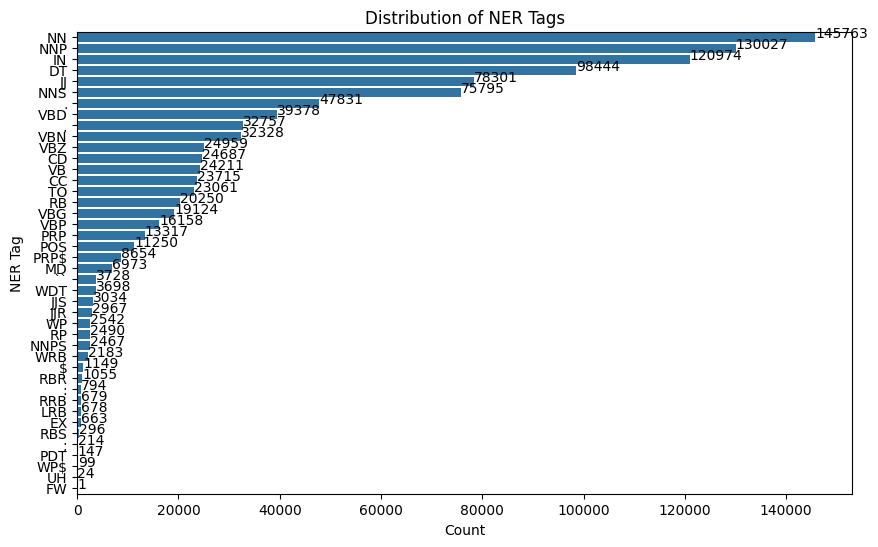

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
# Distribution of NER tags
plt.figure(figsize=(10, 6))
sns.countplot(y='POS', data=data, order = data['POS'].value_counts().index)
plt.title('Distribution of NER Tags')
plt.xlabel('Count')
plt.ylabel('NER Tag')

# Add counts on top of the bars with a gap
for i in range(len(data['POS'].value_counts())):
    plt.text(data['POS'].value_counts()[i] + 1.5, i, data['POS'].value_counts()[i], ha='left')

plt.show()

In [18]:
# Get value counts for the 'POS' column
ner_tag_counts = data['POS'].value_counts()

# Create a DataFrame to display the counts
ner_tag_table = pd.DataFrame({'NER Tag': ner_tag_counts.index, 'Count': ner_tag_counts.values})

# Sort the table by count in descending order
ner_tag_table = ner_tag_table.sort_values(by='Count', ascending=False)

# Display the table
print(ner_tag_table)

   NER Tag   Count
0       NN  145763
1      NNP  130027
2       IN  120974
3       DT   98444
4       JJ   78301
5      NNS   75795
6        .   47831
7      VBD   39378
8        ,   32757
9      VBN   32328
10     VBZ   24959
11      CD   24687
12      VB   24211
13      CC   23715
14      TO   23061
15      RB   20250
16     VBG   19124
17     VBP   16158
18     PRP   13317
19     POS   11250
20    PRP$    8654
21      MD    6973
22      ``    3728
23     WDT    3698
24     JJS    3034
25     JJR    2967
26      WP    2542
27      RP    2490
28    NNPS    2467
29     WRB    2183
30       $    1149
31     RBR    1055
32       :     794
33     RRB     679
34     LRB     678
35      EX     663
36     RBS     296
37       ;     214
38     PDT     147
39     WP$      99
40      UH      24
41      FW       1


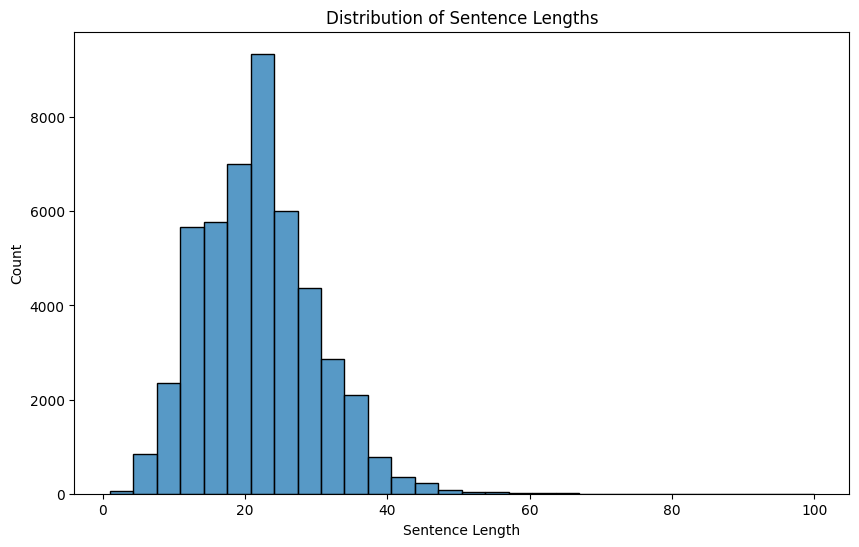

        Sentence #  Sentence Length
0      Sentence: 1               24
1     Sentence: 10               25
2    Sentence: 100               32
3   Sentence: 1000               11
4  Sentence: 10000               35


In [19]:
# Distribution of sentence lengths
sentence_lengths = data.groupby('Sentence #')['Word'].count()
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.show()
# Create DataFrame for sentence lengths
sentence_lengths_df = pd.DataFrame({'Sentence #': sentence_lengths.index, 'Sentence Length': sentence_lengths.values})

# Display the DataFrame
print(sentence_lengths_df.head())

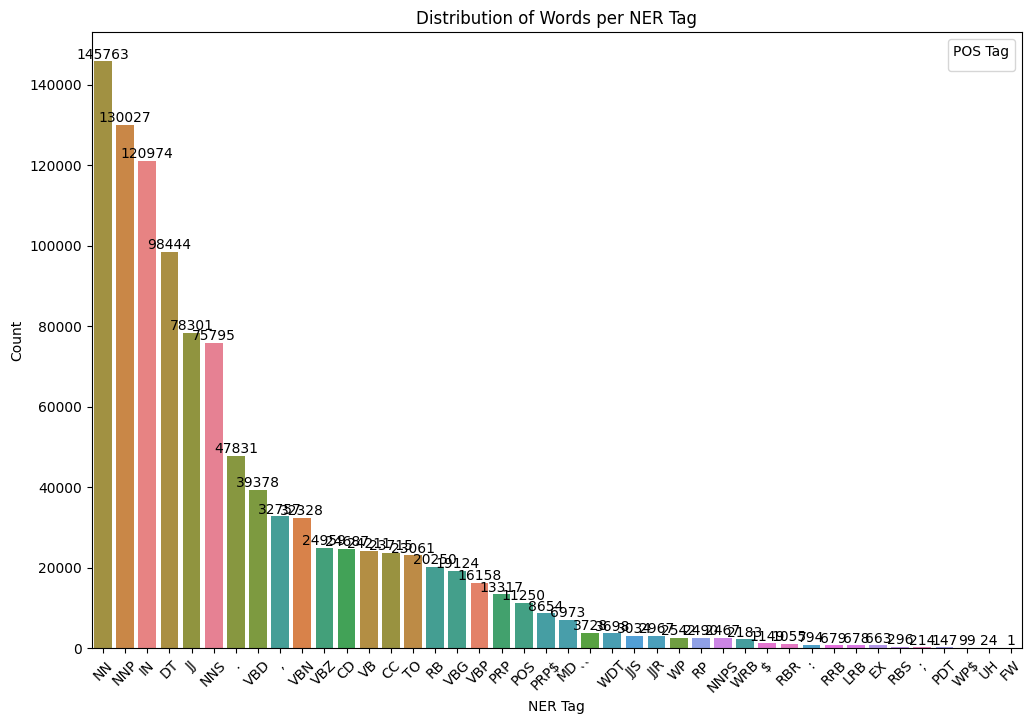

In [20]:
# Distribution of words per NER tag
plt.figure(figsize=(12, 8))
sns.countplot(x='POS', data=data, hue='POS', order = data['POS'].value_counts().index)
plt.title('Distribution of Words per NER Tag')
plt.xlabel('NER Tag')
plt.ylabel('Count')
plt.legend(title='POS Tag')
plt.xticks(rotation=45)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()



In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Summary statistics for all columns
print("\nSummary Statistics for  Columns:")
print(data1.describe(include="all"))



Summary Statistics for  Columns:
             Sentence #     Word      POS      Tag
count           1046865  1046865  1046865  1046865
unique            47920    34989       42       10
top     Sentence: 22480      the       NN        O
freq                100    52572   145763   887908


In [22]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [23]:
data['Sentence #'] = LabelEncoder().fit_transform(data['Sentence #'])


In [25]:
data.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [26]:
# Make necessary changes to use simple transformer model
data.rename(columns = {'Sentence #':'sentence_id',
                       'Word':'words',
                       'Tag':'label'},inplace = True)
labels = data['label'].unique().tolist()
labels

['O',
 'B-GEO',
 'B-GPE',
 'B-PER',
 'I-GEO',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'I-PER',
 'I-TIM']

In [27]:
X = data[['sentence_id','words']]
y = data['label']


In [29]:
from sklearn.model_selection import train_test_split

# Split the data into train and temp sets (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temp data into test and validation sets (20% test, 10% validation)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Convert into DataFrames
train_data = pd.DataFrame({"sentence_id": X_train["sentence_id"], "words": X_train["words"], "labels": y_train})
test_data = pd.DataFrame({"sentence_id": X_test["sentence_id"], "words": X_test["words"], "labels": y_test})
val_data = pd.DataFrame({"sentence_id": X_val["sentence_id"], "words": X_val["words"], "labels": y_val})


In [30]:
labels = data['label'].unique().tolist()
labels

['O',
 'B-GEO',
 'B-GPE',
 'B-PER',
 'I-GEO',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'I-PER',
 'I-TIM']

In [33]:
!pip install simpletransformers

In [34]:
from simpletransformers.ner import NERModel , NERArgs

In [35]:
args = NERArgs()
args.num_train_epochs = 1
args.learning_rate = 1e-4
args.overwrite_output_dir = True
args.train_batch_size = 32
args.eval_batch_size = 32

In [36]:
model = NERModel('bert','bert-base-cased',labels = labels , args = args)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [37]:
model.train_model(train_data , eval_data = test_data , acc = accuracy_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1498 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


(1498, 0.1840317575845405)

In [38]:
result, model_outputs, preds_list = model.eval_model(test_data)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1458 [00:00<?, ?it/s]

In [39]:
result

{'eval_loss': 0.1578656230102688,
 'precision': 0.831540223502464,
 'recall': 0.7770894820484546,
 'f1_score': 0.8033932972320486}

In [40]:
result, model_outputs, preds_list = model.eval_model(val_data)
result

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1294 [00:00<?, ?it/s]

{'eval_loss': 0.16801583073735293,
 'precision': 0.8250397951415323,
 'recall': 0.7662788455357716,
 'f1_score': 0.7945744184496434}

In [41]:
data1.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [42]:
# Fine Tuning bert model on our data

# let's create a new column called "sentence" which groups the words by sentence
data1['sentence'] = data1[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence
data1['word_labels'] = data1[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data1.head()

,Sentence #,Word,POS,Tag,sentence,word_labels
0,Sentence: 1,Thousands,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
1,Sentence: 1,of,IN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
2,Sentence: 1,demonstrators,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
3,Sentence: 1,have,VBP,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
4,Sentence: 1,marched,VBN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."


In [43]:
label2id = {k: v for v, k in enumerate(data1.Tag.unique())}
id2label = {v: k for v, k in enumerate(data1.Tag.unique())}
label2id

{'O': 0,
 'B-GEO': 1,
 'B-GPE': 2,
 'B-PER': 3,
 'I-GEO': 4,
 'B-ORG': 5,
 'I-ORG': 6,
 'B-TIM': 7,
 'I-PER': 8,
 'I-TIM': 9}

In [44]:
data1 = data1[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data1.head()

,sentence,word_labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-PER,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-GEO,I-GEO,O"
3,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-GEO,O,O,B-ORG,I-ORG,O,..."


In [45]:
len(data1)

47571

In [46]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [47]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [48]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index]
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)

        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]

        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }

    def __len__(self):
        return self.len


In [49]:
from sklearn.model_selection import train_test_split

# Define the train size and validation size
train_size = 0.7
val_size = 0.1

# Split the data into train and temp sets (70% train, 30% temp)
train_data, temp_data = train_test_split(data1, train_size=train_size, random_state=200)

# Split the temp data into test and validation sets (20% test, 10% validation)
test_data, val_data = train_test_split(temp_data, test_size=val_size/(1-train_size), random_state=200)

print("FULL Dataset: {}".format(data1.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))
print("VAL Dataset: {}".format(val_data.shape))

# Assuming you have defined the dataset class as 'dataset' and tokenizer is initialized
training_set = dataset(train_data, tokenizer, MAX_LEN)
testing_set = dataset(test_data, tokenizer, MAX_LEN)
val_set = dataset(val_data, tokenizer, MAX_LEN)


FULL Dataset: (47571, 2)
TRAIN Dataset: (33299, 2)
TEST Dataset: (9514, 2)
VAL Dataset: (4758, 2)


In [63]:
train_size = 0.8
train_dataset = data1.sample(frac=train_size,random_state=200)
test_dataset = data1.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data1.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (47571, 2)
TRAIN Dataset: (38057, 2)
TEST Dataset: (9514, 2)


In [64]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)


In [65]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [66]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(2.2601, device='cuda:0', grad_fn=<NllLossBackward0>)

In [67]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 10])

In [68]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [70]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 2.1617684364318848
Training loss per 100 training steps: 0.3885725193315803
Training loss per 100 training steps: 0.2544944502635678
Training loss per 100 training steps: 0.20079826862486297
Training loss per 100 training steps: 0.16883924895284366
Training loss per 100 training steps: 0.1461467249532734
Training loss per 100 training steps: 0.13072301011870363
Training loss per 100 training steps: 0.11872574182150197
Training loss per 100 training steps: 0.10966381809724199
Training loss per 100 training steps: 0.10275378942460682
Training loss per 100 training steps: 0.0968232907887016
Training loss per 100 training steps: 0.09184992841515119
Training loss per 100 training steps: 0.08752824621023819
Training loss per 100 training steps: 0.08398960913881534
Training loss per 100 training steps: 0.08095168251594759
Training loss per 100 training steps: 0.07838857079174204
Training loss per 100 training steps: 0.07604077943319457
T

In [71]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [72]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.1209251880645752
Validation loss per 100 evaluation steps: 0.022169984129342794
Validation loss per 100 evaluation steps: 0.02257344536630979
Validation loss per 100 evaluation steps: 0.02174456845367547
Validation loss per 100 evaluation steps: 0.02270164261319491
Validation loss per 100 evaluation steps: 0.022934342578685277
Validation loss per 100 evaluation steps: 0.022810936332822173
Validation loss per 100 evaluation steps: 0.0231860539762976
Validation loss per 100 evaluation steps: 0.02323748037360134
Validation loss per 100 evaluation steps: 0.02386440697972104
Validation loss per 100 evaluation steps: 0.024888785707838004
Validation loss per 100 evaluation steps: 0.024897480166320422
Validation loss per 100 evaluation steps: 0.02466797455957481
Validation loss per 100 evaluation steps: 0.02464202191718319
Validation loss per 100 evaluation steps: 0.024383991994996582
Validation loss per 100 evaluation steps: 0.02479589048961595
Vali

In [73]:
from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))

              precision    recall  f1-score   support

         GEO       0.85      0.86      0.85     11232
         GPE       0.94      0.92      0.93      3293
         ORG       0.67      0.67      0.67      6531
         PER       0.76      0.79      0.78      5196
         TIM       0.86      0.82      0.84      4360

   micro avg       0.81      0.81      0.81     30612
   macro avg       0.82      0.81      0.81     30612
weighted avg       0.81      0.81      0.81     30612



In [74]:
sentence = "India has a capital called Mumbai. On wednesday, the president will give a presentation"

inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

word_level_predictions = []
for pair in wp_preds:
  if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
    # skip prediction
    continue
  else:
    word_level_predictions.append(pair[1])

# we join tokens, if they are not special ones
str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
print(str_rep)
print(word_level_predictions)

india has a capital called mumbai . on wednesday , the president will give a presentation
['B-GEO', 'O', 'O', 'O', 'O', 'B-GEO', 'O', 'O', 'B-TIM', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [75]:
from transformers import pipeline

pipe = pipeline(task="token-classification", model=model.to("cpu"), tokenizer=tokenizer, aggregation_strategy="simple")
pipe("My name is Rajat and Gurgaon is a city")

[{'entity_group': 'PER',
  'score': 0.529624,
  'word': 'raja',
  'start': None,
  'end': None},
 {'entity_group': 'PER',
  'score': 0.40696165,
  'word': '##t',
  'start': None,
  'end': None},
 {'entity_group': 'GEO',
  'score': 0.83431345,
  'word': 'gu',
  'start': None,
  'end': None},
 {'entity_group': 'GEO',
  'score': 0.76449955,
  'word': '##rga',
  'start': None,
  'end': None},
 {'entity_group': 'GEO',
  'score': 0.7799968,
  'word': '##on',
  'start': None,
  'end': None}]

In [76]:
import pickle
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))